# Работа с изображениями. Сверточные нейронные сети

**Цель этого занятия** - знакомство со сверточными сетями и transfer learning на примере классификации изображений. План:

* Convolution, Pooling - базовые слои, их гиперпараметры и интуиция использования;

* Построение сверточной нейросети для классификации картинок;

* Использование Transfer Learning для этой же задачи.

### Введение в computer vision

На текущий момент очень много данных представлены в виде изображдений и видео, нужно уметь решать задачи анализа изображений. 

**Примеры использования CV**:
- Беспилотные автомобили
- Медицина
- Системы видеонаблюдения
- Системы дополненной реальности
- Системы контроля качества на производстве

**Задачи при работе с изображениями**

- Классфикации

![](https://github.com/LinNikMIPT/ML-course-2019/blob/master/Lectures/Lecture_03/images/signs.jpg?raw=true)

- Сигментация

![](https://cdn-images-1.medium.com/max/1200/1*USmkmfMq7C5mrrLpYCXxUA.png)

- Детекция

![](https://marker.im/wp-content/uploads/2022/02/yolo-object-detection.webp)

!!!!!!!!!!!!!!!!!!!!!!!!

Преамбула: сейчас много данных в виде изображдений и видео, нужно решать задачи анализа изображений. 

Одна из простейших задач и "hello world" в computer vision - задача классификации рукописных цифр из датасета MNIST

Идея - решить эту задачу уже знакомым методом, а именно с помощью полносвязной сети. Цели: освежить в памяти работу с  полносвязными сетями, увидеть теоритеческую возможность и минусы такого подхода

### Задача классификации

Рассмотрим один из примеров задачи CV - задачу классификации изображений. База данных MNIST - "hello world" в computer vision, содержит 60000 черно-белых изображений для обучения и 10000 изображений для тестирования. Размеры изображений 28x28 пикселей.

![](https://camo.githubusercontent.com/01c057a753e92a9bc70b8c45d62b295431851c09cffadf53106fc0aea7e2843f/687474703a2f2f692e7974696d672e636f6d2f76692f3051493378675875422d512f687164656661756c742e6a7067)

Решение задачи классификации на этом датасет очень много где подробно разобрано, поэтому мы будем использовать другой набор данных.

**CIFAR10**

Датасет состоит из 60k картинок размером 32х32х3. 

50k - обучающая выборка, 10k - тестовая. 

10 классов: 'plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'.

 ![](https://sun9-72.userapi.com/c857216/v857216523/12dbca/vdSCet5LS_0.jpg)

На примере этого датасета рассмотрим задачу бинарной классификации изображений. Задача - научиться отличать самолеты от машин

In [ ]:
import torch
import torch.nn as nn
import torchvision
from collections import defaultdict
import time
from torchsummary import summary
import torch.optim as optim
import numpy as np


import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline

device_num = 0
device = f"cuda:{device_num}" if torch.cuda.is_available() else "cpu"

print(f"Device: {device}")

Device: cuda:0


In [ ]:
# загружаем тренировочный датасет CIFAR10
dataset = torchvision.datasets.CIFAR10(
    root='./data', 
    train=True,
    download=True, 
    transform=torchvision.transforms.ToTensor()
)

# выберем изображения с метками 0 или 1 (так как сейчас решаем задачу бинарной классификации)
idx = (np.array(dataset.targets)==0) | (np.array(dataset.targets)==1)
dataset.targets = np.array(dataset.targets)[idx]
dataset.data = np.array(dataset.data)[idx]

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


In [ ]:
# разделим выборку на обучение и валидацию
train_dataset, val_dataset = torch.utils.data.random_split(
    dataset, [8000, 2000]
)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
# загружаем тестовый датасет CIFAR10
test_dataset = torchvision.datasets.CIFAR10(
    root='./data', 
    train=False,
    download=True, 
    transform=torchvision.transforms.ToTensor()
)

# выберем изображения с метками 0 или 1
idx = (np.array(test_dataset.targets)==0) | (np.array(test_dataset.targets)==1)
test_dataset.targets = np.array(test_dataset.targets)[idx]
test_dataset.data = np.array(test_dataset.data)[idx]

Files already downloaded and verified


In [ ]:
print(f"Images in train dataset: {len(train_dataset)}")
print(f"Images in val dataset: {len(val_dataset)}")
print(f"Images in test dataset: {len(test_dataset)}")

Images in train dataset: 8000
Images in val dataset: 2000
Images in test dataset: 2000


In [ ]:
# Создаем загрузчики для датасетов

batch_size_train = 64
batch_size_test = 1000

train_loader = torch.utils.data.DataLoader(
  train_dataset,
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  test_dataset,
  batch_size=batch_size_test, shuffle=True)

In [ ]:
# Посмотрим размер тестового датасета

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

print(example_data.shape)
print(example_targets.shape)

torch.Size([1000, 3, 32, 32])
torch.Size([1000])


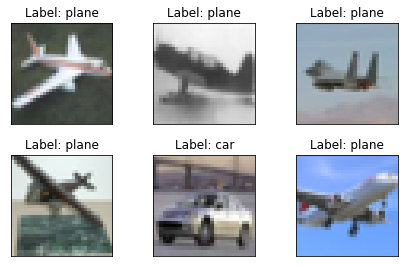

In [ ]:
# Визуализируем несколько изображений из тестового датасета

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(np.transpose(example_data[i], (1, 2, 0)), interpolation='none')
  plt.title(f"Label: {classes[example_targets[i]]}")
  plt.xticks([])
  plt.yticks([])

### Практическое задание №1 
Реализовать и обучить полносвязную сеть для решения задачи бинарной классификации

In [ ]:
# your code here

# Создаем класс нейронной сети
class BinaryClassification(nn.Module):
    def __init__(self):
        super(BinaryClassification, self).__init__()
        self.layer_1 = nn.Linear(32*32*3, 1024) 
        self.layer_2 = nn.Linear(1024, 256)
        self.layer_3 = nn.Linear(256, 64)
        self.layer_4 = nn.Linear(64, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(1024)
        self.batchnorm2 = nn.BatchNorm1d(256)
        
    def forward(self, inputs):
        x = torch.flatten(inputs, 1)
        x = self.relu(self.layer_1(x))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.relu(self.layer_3(x))
        x = self.layer_4(x)
        return x


# Переносим сеть на device
model = BinaryClassification().to(device)

# Посмотрим на модель и количество параметров 
print(model)
summary(model, (3, 32, 32))

BinaryClassification(
  (layer_1): Linear(in_features=3072, out_features=1024, bias=True)
  (layer_2): Linear(in_features=1024, out_features=256, bias=True)
  (layer_3): Linear(in_features=256, out_features=64, bias=True)
  (layer_4): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1024]       3,146,752
              ReLU-2                 [-1, 1024]               0
       BatchNorm1d-3                 [-1, 1024]           2,048
            Linear-4                  [-1, 256]         262,400
              ReLU-5                  [-1, 256]               0
       Ba

In [ ]:
# your code here

# Зададим функциию потерь и оптимизатор
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def binary_acc(y_pred, y_test):
  """
  Функция подсчета точности классификации
  """
  y_pred_tag = torch.round(torch.sigmoid(y_pred))

  correct_results_sum = (y_pred_tag == y_test).sum().float()
  acc = correct_results_sum/y_test.shape[0]
  acc = torch.round(acc * 100)
  
  return acc

In [ ]:
# your code here

# Переводим модель в режим обучения
model.train()

# Обучаем сеть (цикл по эпохам)
for e in range(1, 20):
  # Зануляем значение функции потерь и точности на данной эпохе
  epoch_loss = 0
  epoch_acc = 0

  # Цикл по батчам из загручика обучающего датасета
  for X_batch, y_batch in train_loader:
    # Переносим батчи на device (туда же куда перенесли модель)
    X_batch, y_batch = X_batch.to(device), y_batch.to(device)

    # Обнуляем градиент
    optimizer.zero_grad()
    
    # Делаем предсазание (forward)
    y_pred = model(X_batch)
    
    # Считаем значение функции потерь и точности
    loss = criterion(y_pred.float(), y_batch.unsqueeze(1).float())
    acc = binary_acc(y_pred.float(), y_batch.unsqueeze(1).float())
    
    # Считаем градиенты (backward) и делаем шаг оптимизатора (обновляем веса)
    loss.backward()
    optimizer.step()
    
    # Сохраняем значение функции потерь и точности на эпохе
    epoch_loss += loss.item()
    epoch_acc += acc.item()
      

  print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

Epoch 001: | Loss: 0.41727 | Acc: 81.248
Epoch 002: | Loss: 0.36030 | Acc: 84.128
Epoch 003: | Loss: 0.33103 | Acc: 85.272
Epoch 004: | Loss: 0.30653 | Acc: 86.952
Epoch 005: | Loss: 0.28340 | Acc: 87.912
Epoch 006: | Loss: 0.28314 | Acc: 87.848
Epoch 007: | Loss: 0.26828 | Acc: 88.672
Epoch 008: | Loss: 0.25332 | Acc: 89.280
Epoch 009: | Loss: 0.24663 | Acc: 89.976
Epoch 010: | Loss: 0.22157 | Acc: 91.024
Epoch 011: | Loss: 0.22860 | Acc: 90.568
Epoch 012: | Loss: 0.21587 | Acc: 91.112
Epoch 013: | Loss: 0.20193 | Acc: 91.800
Epoch 014: | Loss: 0.20061 | Acc: 91.856
Epoch 015: | Loss: 0.18473 | Acc: 92.488
Epoch 016: | Loss: 0.16415 | Acc: 93.392
Epoch 017: | Loss: 0.16674 | Acc: 93.104
Epoch 018: | Loss: 0.16319 | Acc: 93.592
Epoch 019: | Loss: 0.16027 | Acc: 93.496


### Почему полносвязные сети плохи для работы с изображениями

- Размеры изображений как правило достаточно большие (например, 1024x1024x3)
- Нужно много параметров, долгое обучение и медленная работа
- Не используется информация о близости соседних пикселях (при вытягивании в вектор)
- Не инвариантно относительно положения объекта на фотографии
- Сложно обучать, нужен очень большой dataset, склонность к переобучению

### Концептуально новый подход к работе с изображениями - свертка

Основные гиперпараметры:

* `in_channels` (int) - количество каналов во входном изображении

* `out_channels` (int) - количество каналов после применения свертки (кол-во ядер (фильтров), которые будут применены)

* `kernel_size` (int, tuple) - размер сверточного ядра

* `stride` (int, tuple) - шаг, с которым будет применена свертка. Значение по умолчанию 1

* `padding` (int, tuple) - добавление по краям изображения дополнительных пикселей. Значение по умолчанию 0

* `padding_mode` (string, optional) - принцип заполнения краёв. Значение по умолчанию 'zeros'

`nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, stride=2, padding=1, padding_mode='zeros')`
 ![](http://deeplearning.net/software/theano/_images/numerical_padding_strides.gif)

 Берем `out_channels` фильтров размера  `in_channels` x `kernel_size` x `kernel_size`. Каждым фильтром 'проходим' по изображению с шагом `stride`, поэлементно умножаем его на область изображения размером `in_channels` x `kernel_size` x `kernel_size`, складываем получившиеся поэлемнетные произведения и записываем это число в результирующий тензор. В итоге получаем `out_channels` выходных тензоров.

 **Интуиция**:
 
В FC слоях мы соединяли нейрон с каждым нейроном на предыдущем слое. Теперь нейрон соединен только с ограниченной областью выхода предыдущего слоя. Иногда эту область называют *рецептивном полем (receiptive field)* нейрона. 

Такое изменение необходимо из-за большой размерности входных данных. Например, если размер входного изображения $3 \cdot 224 \cdot 224$, то каждый нейроне в FC-слое будет содержать $3\cdot 224\cdot 224=150\:528$ параметров, что очень много. При этом мы захотим добавить нелинейности в нашу архитектуру, так что у нас будет несколько таких слоёв.



![](https://upload.wikimedia.org/wikipedia/commons/1/19/2D_Convolution_Animation.gif)

![](https://habrastorage.org/getpro/habr/upload_files/b20/a44/78e/b20a4478eb91bb308e9d852dbbb0892b.gif)

![](https://neerc.ifmo.ru/wiki/images/5/5c/Convolution-operation-on-volume5.png)

![](https://habrastorage.org/getpro/habr/upload_files/129/d1c/c85/129d1cc85da6b81d9f8fcc0b80ff93b8.gif)

*Задача на понимание:*

К изображению (3, 224, 224) применяют свертку `nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, stride=2, padding=2, bias=True)`. 

* Какой будет размер выходного изображения? 

(224 - 5 + 4) // 2 + 1 = 111 + 1 = 112

= (64, 112, 112)

* Cколько у данного слоя обучаемых параметров?

5 * 5 * 3 * 64 + 64

### Слой Pooling

Основные гиперпараметры:

* `kernel_size` (int, tuple) - размер ядра

* `stride` (int, tuple) - шаг, с которым будет применен pooling. Значение по умолчанию `kernel_size`

* `padding` (int, tuple) - добавление по краям изображения нулей

Основные виды pooling-ов: `MaxPooling` (берется максимум элементов), `AveragePooling` (берется среднее элементов).

![](https://sun9-10.userapi.com/c854016/v854016674/22a457/mpE8Idra-5Y.jpg)

**Интуиция:**

1. cнижаем размерность изображения и, как следствие, вычислительную сложность

2. увеличиваем рецептивное поле на входном изображении для нейронов следующих сверточных слоев

При этом многие исследователи ставят под сомнение эффективность pooling слоёв. Например, в статье [Striving for Simplicity: The All Convolutional Net](https://arxiv.org/abs/1412.6806) предлагается заменить его на свертки с большим stride-ом. Также считается, что отсутствие pooling слоёв хорошо сказывается на обучении генеративных моделей, но споры ещё ведутся: [FCC-GAN: A Fully Connected and Convolutional Net
Architecture for GANs](https://arxiv.org/pdf/1905.02417.pdf)

![](https://neerc.ifmo.ru/wiki/images/8/8d/Maxpool.jpeg)

*Последовательное применение слоев*
- Свертка
- Pooling
- Активация

позволяет выделять признаки, уменьшая размер изображения

! анимации сверток: https://github.com/vdumoulin/conv_arithmetic

### Фильтры

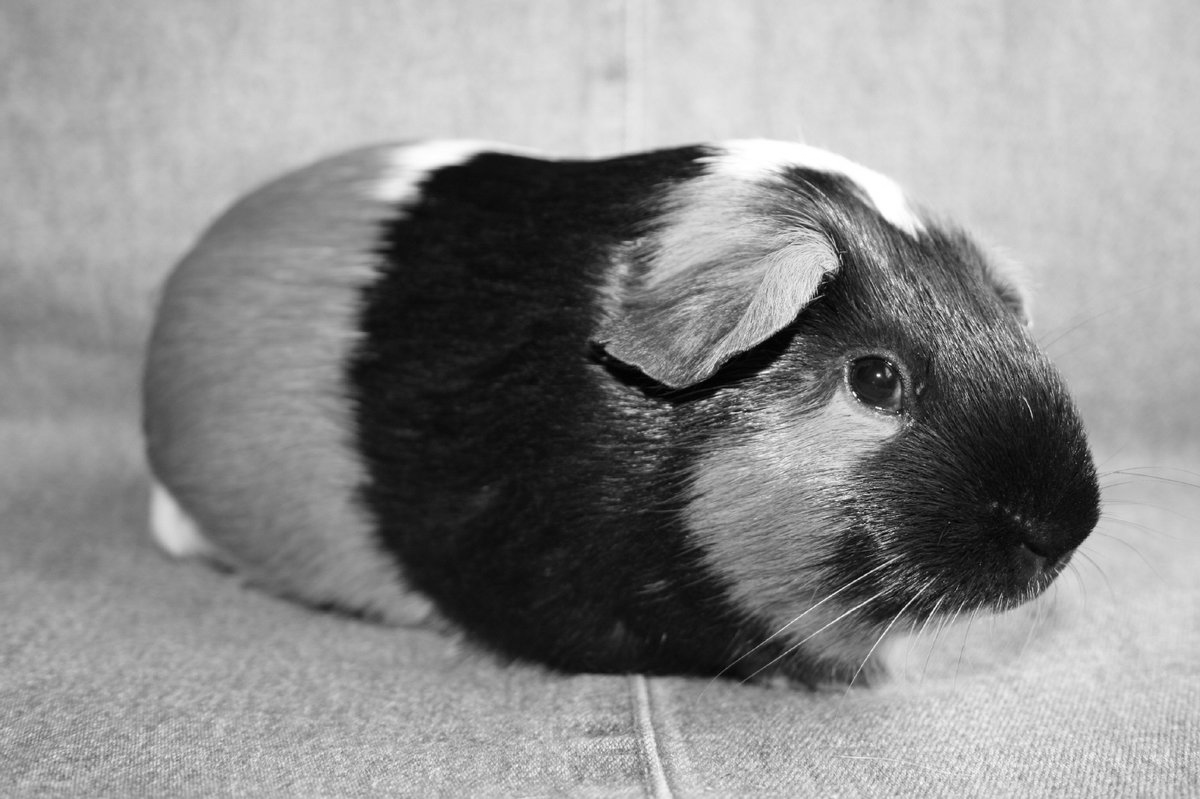

In [ ]:
import numpy as np 
import cv2 
import urllib.request
from google.colab.patches import cv2_imshow

# Получаем картинку по ссылке
req = urllib.request.urlopen('http://klubmama.ru/uploads/posts/2022-08/1661821262_36-klubmama-ru-p-podelka-morskaya-svinka-foto-36.jpg')
# Переводим картинку в np.array
arr = np.asarray(bytearray(req.read()), dtype=np.uint8)

# Переводим изображение в чб и отображаем
img = cv2.imdecode(arr, -1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

cv2_imshow(img)

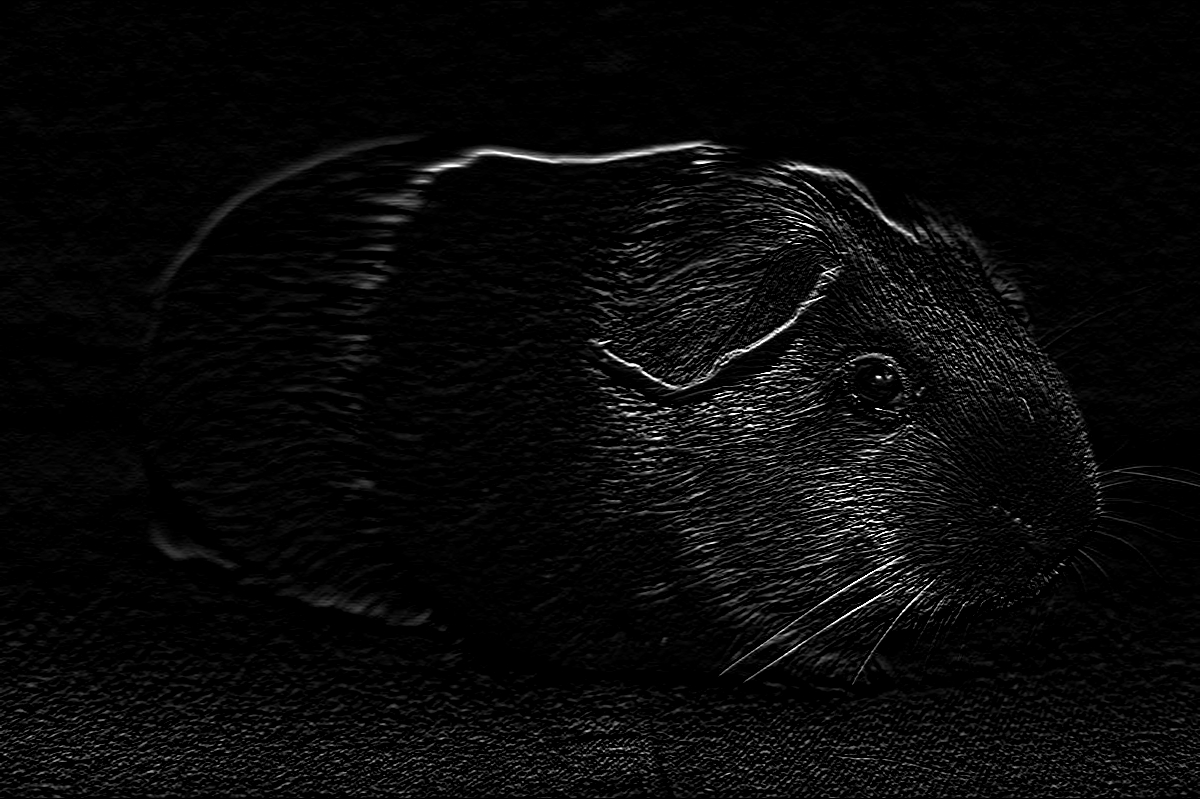

In [ ]:
kernel = np.array([[1.0, 1.0, 1.0], 
                   [0.0, 0.0, 0.0], 
                   [-1.0, -1.0, -1.0]])
kernel = kernel/(np.sum(kernel) if np.sum(kernel)!=0 else 1) 

# Применим ядро выше к нашему изображению
img_rst = cv2.filter2D(img,-1,kernel)
cv2_imshow(img_rst)

### Практическое задание №2
C помощью фильтра выделить вертикальные линии на изображении


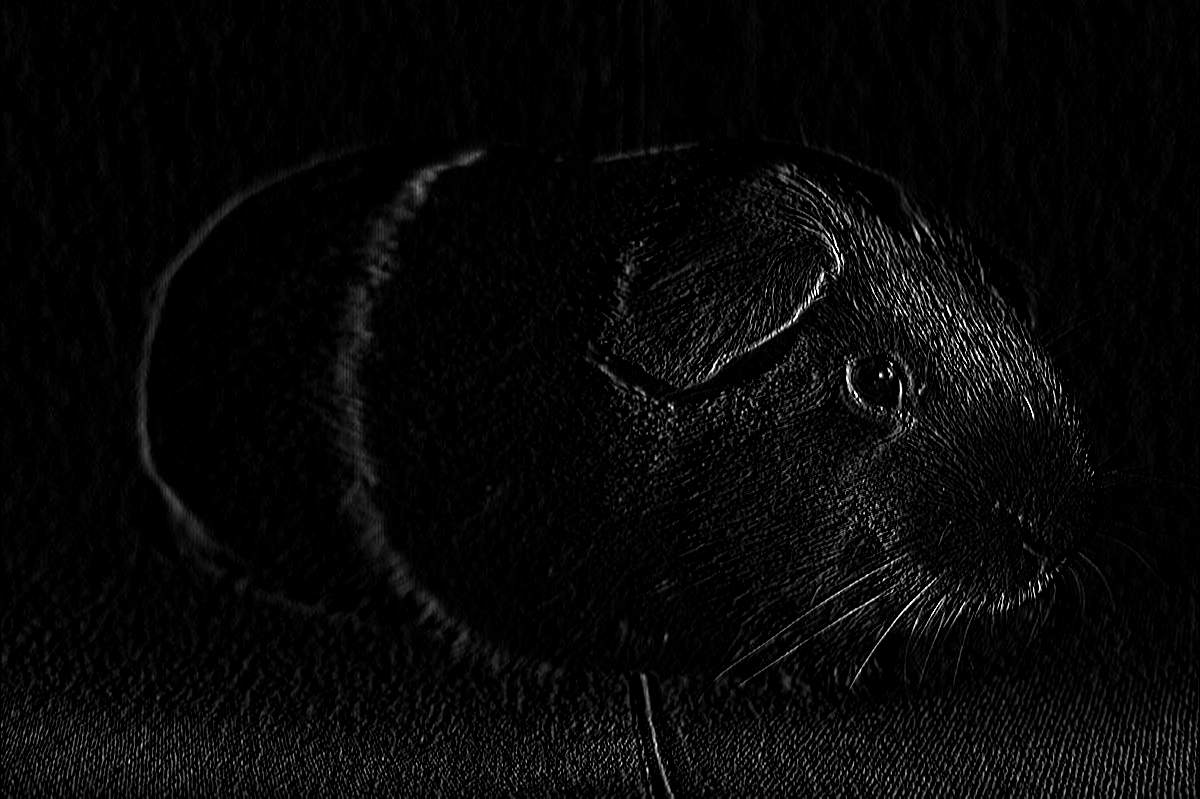

In [ ]:
# your code here

kernel = np.array([[1.0, 0.0, -1.0], 
                   [1.0, 0.0, -1.0], 
                   [1.0, 0.0, -1.0]])

kernel = kernel/(np.sum(kernel) if np.sum(kernel)!=0 else 1) 
img_rst = cv2.filter2D(img,-1,kernel)
cv2_imshow(img_rst)

### Реализация сверточной нейронной сети

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
# Загрузку и подготовку данных уже делали

dataset = torchvision.datasets.CIFAR10(
    root='./data', 
    train=True,
    download=True, 
    transform=torchvision.transforms.ToTensor()
)

# разделили выборку на обучение и валидацию
train_dataset, val_dataset = torch.utils.data.random_split(
    dataset, [40000, 10000]
)

test_dataset = torchvision.datasets.CIFAR10(
    root='./data', 
    train=False,
    download=True, 
    transform=torchvision.transforms.ToTensor()
)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
batch_size = 64

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False
)

In [ ]:
# Создаем класс сверточной нейронной сети
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = nn.Sequential(            
          # Блок 1: Свёртка с большим ядром, чтобы уловить общие закономерности
          nn.Conv2d(3, 16, kernel_size=5, padding=2),
          # Важно! Батч-нормализация всегда идёт до функции активации!
          nn.BatchNorm2d(16),
          nn.MaxPool2d(2),
          nn.Dropout(0.2),

          # Блок 2: Свёртка с ядром поменьше, выделяет более тонкие признаки.
          nn.Conv2d(16, 32, kernel_size=3, padding=1),
          nn.BatchNorm2d(32),
          nn.MaxPool2d(2),
          # Важно! Дропаут идёт после функции активации!
          nn.Dropout(0.2)
        )

        self.classifier = nn.Sequential(
          # Блок 3: Линейный слой поверх карт активации
          nn.Linear(2048, 512),
          nn.BatchNorm1d(512),
          nn.ReLU(),
          nn.Dropout(0.2),

          # Блок 4: Классификационный слой
          nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Переносим CNN на device
model = CNN().to(device)

In [ ]:
# Посмотрим на модель
model

CNN(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.2, inplace=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.2, inplace=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=2048, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [ ]:
# Посмотрим на модель и на количество параметров в каждом слое
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]           1,216
       BatchNorm2d-2           [-1, 16, 32, 32]              32
         MaxPool2d-3           [-1, 16, 16, 16]               0
           Dropout-4           [-1, 16, 16, 16]               0
            Conv2d-5           [-1, 32, 16, 16]           4,640
       BatchNorm2d-6           [-1, 32, 16, 16]              64
         MaxPool2d-7             [-1, 32, 8, 8]               0
           Dropout-8             [-1, 32, 8, 8]               0
            Linear-9                  [-1, 512]       1,049,088
      BatchNorm1d-10                  [-1, 512]           1,024
             ReLU-11                  [-1, 512]               0
          Dropout-12                  [-1, 512]               0
           Linear-13                   [-1, 10]           5,130
Total params: 1,061,194
Trainable param

In [ ]:
def plot_learning_curves(history):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.

    :param history: (dict)
        accuracy и loss на обучении и валидации
    '''
    fig = plt.figure(figsize=(20, 7))

    plt.subplot(1,2,1)
    plt.title('Лосс', fontsize=15)
    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()

    plt.subplot(1,2,2)
    plt.title('Точность', fontsize=15)
    plt.plot(history['acc']['train'], label='train')
    plt.plot(history['acc']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()
    plt.show()

In [ ]:
def train(
    model, 
    criterion,
    optimizer, 
    train_batch_gen,
    val_batch_gen,
    num_epochs=50
):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.

    :param model: обучаемая модель
    :param criterion: функция потерь
    :param optimizer: метод оптимизации
    :param train_batch_gen: генератор батчей для обучения
    :param val_batch_gen: генератор батчей для валидации
    :param num_epochs: количество эпох

    :return: обученная модель
    :return: (dict) accuracy и loss на обучении и валидации ("история" обучения)
    '''

    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0
        
        start_time = time.time()

        # Устанавливаем поведение dropout / batch_norm  в обучение
        model.train(True) 

        # На каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            # Обучаемся на батче (одна "итерация" обучения нейросети)
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            logits = model(X_batch)
            
            loss = criterion(logits, y_batch.long().to(device))

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            train_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            train_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # Подсчитываем лоссы и сохраням в "историю"
        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen) 
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)
    
        # Устанавливаем поведение dropout / batch_norm в режим тестирования
        model.train(False)

        # Полный проход по валидации    
        for X_batch, y_batch in val_batch_gen:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            # Так как это не обучающие батчи, градиент не нужен
            with torch.no_grad():
                logits = model(X_batch)
                
            loss = criterion(logits, y_batch.long().to(device))
            val_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            val_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # Подсчитываем лоссы и сохраням в "историю"
        val_loss /= len(val_batch_gen)
        val_acc /= len(val_batch_gen) 
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)
        
        clear_output()

        # Печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))
        
        plot_learning_curves(history)
        
    return model, history

Epoch 50 of 50 took 3.393s
  training loss (in-iteration): 	0.446844
  validation loss (in-iteration): 	1.286754
  training accuracy: 			85.87 %
  validation accuracy: 			57.71 %


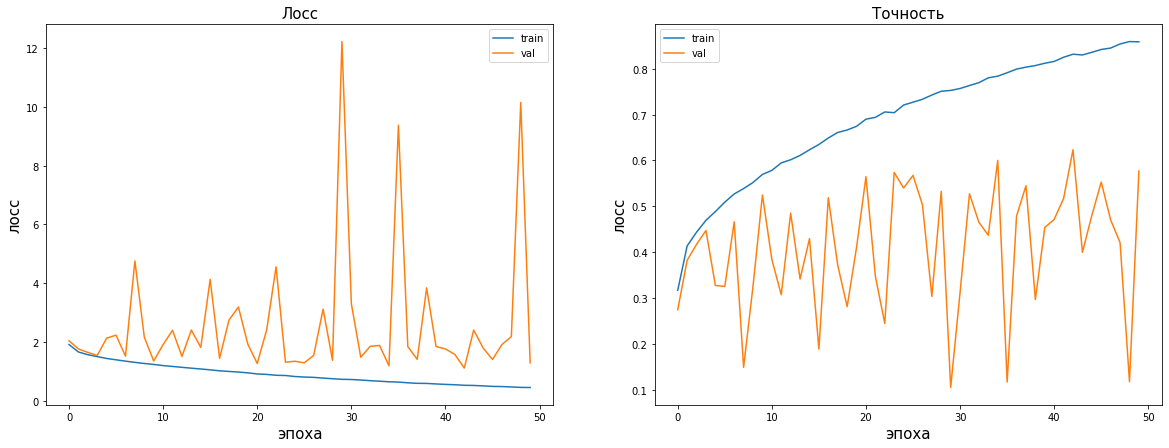

In [ ]:
# Зададим функциию потерь и оптимизатор
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# Обучим модель
model, history = train(
    model, criterion, optimizer,
    val_loader, test_loader,
    num_epochs=50
)

In [ ]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [ ]:
# Сделаем предсказания обученной сети на тестовом датасете
with torch.no_grad():
  output = model(example_data.to(device))

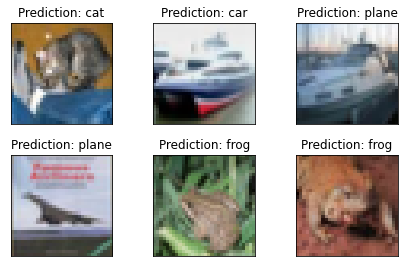

In [ ]:
# Визаулизируем картинки и предсказанные на них классы
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(np.transpose(example_data[i], (1, 2, 0)), interpolation='none')
  plt.title(f"Prediction: {classes[output.data.max(1, keepdim=True)[1][i].item()]}")
  plt.xticks([])
  plt.yticks([])

### Выделение сверточной сетью признаков с помощью фильтров

Давайте визуализируем активации сети, когда через нее проходят изображения. Код ниже рисует таблицу изображений: в первом столбце показаны исходные изображения, в следующих 6 столбцах показаны изображения после применения к ним фильтров.

In [ ]:
# выберем 10 картинок из тестового датасета и применим к ним сверточные слои нашей сети 
for X, y_true in test_loader:
    x = X[:10]
    X = X.to(device)

    y = model.feature_extractor[:1](X)[:10]
    
    break

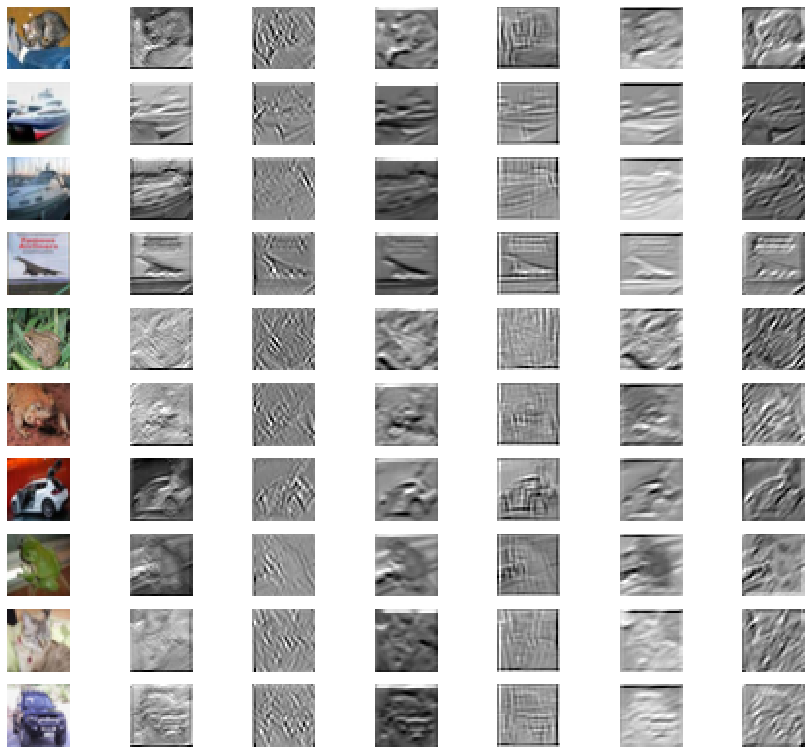

In [ ]:
# Визуализируем результаты
def plot(x, y):
    plt.figure(figsize=(15, 15))
    for im in range(10):
        plt.subplot(11, 7, im*7+1)
        plt.imshow(np.transpose(x.data[im], (1, 2, 0)), interpolation='none')
        plt.axis("off")
        for i in range(6):
            plt.subplot(11, 7, im*7+i+2)
            plt.imshow(y.data[im, i].cpu(), cmap = "gray", interpolation='none')
            plt.axis("off")

plot(x, y)

Теперь визуализируем результат применения части feature_extractor (до второй свертки) к изображениям

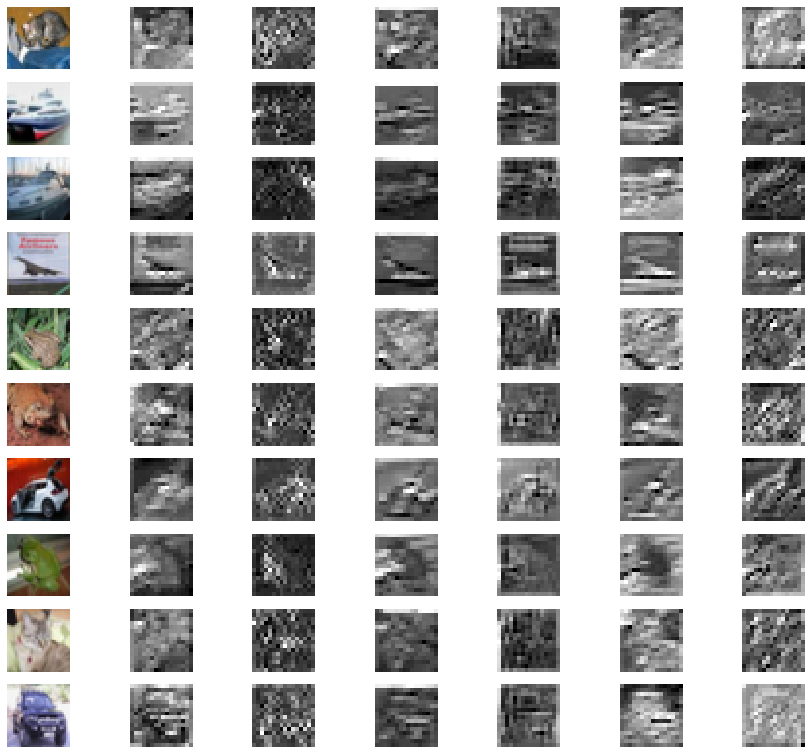

In [ ]:
for X, y_true in test_loader:
    x = X[:10]
    X = X.to(device)

    y = model.feature_extractor[:4](X)[:10]
    
    break
    
plot(x, y)

### Некоторые архитектуры CNN
- LeeNet5 (классификация)
- AlexNet (классификация)
- VGG (классификация)
- GoogleNet (классификация)
- ResNet (классификация)
- DenseNet (классификация)
- EfficientDet (детекция)
- SAUNet (сегментация)
- ENet (сегментация)
- MobileNet (детекция)

![](https://upload.wikimedia.org/wikipedia/commons/thumb/c/cc/Comparison_image_neural_networks.svg/1280px-Comparison_image_neural_networks.svg.png)

**GoogLeNet**

![](https://miro.medium.com/max/4800/1*66hY3zZTf0Lw2ItybiRxyg.png)

**ResNet**

![](https://miro.medium.com/max/720/1*yy6Bbnp38MhcfDQbzOGf4A.png)

**DenseNet**

![](https://pytorch.org/assets/images/densenet1.png)

### Data augmentations. Аугментация изображений

![](https://sun9-5.userapi.com/c857216/v857216818/1815e6/OxQ8e3-o0oU.jpg)

Для обучения нейронных сетей нужны большие объемы данных. Чтобы увеличить размеры обучющей выборки применяют аугментацию данных.

Data augmentations - это метод, направленный на увеличение размеров обучающей выборки. Дополнение обучающей выборки разнообразными, "хорошими" и "плохими" примерами, позволяет получить модель более устойчивую на тестовых данных, так как для неё в тестовых данных будет меньше "неожиданностей".

С помощью `torchvision.transforms` мы применим несколько случайных преобразований к картинкам и тем самым расширим нашу выборку. Про все реализованные в библиотеке преобразования можно почитать [здесь](https://pytorch.org/docs/stable/torchvision/transforms.html).

В данном случае в качестве аугментации мы используем:

* `ColorJitter` - изменение яркости, контраста, насыщенности цветов
* `RandomAffine` - афинное преобразование

**Примеры искажений изображений**
- Сдвиги
- Замена фона
- Искажения, характерные для решаемой задачи: блики, шумы, размытие и т.д.
- Повороты
- Сжатия и растяжения вдоль осей

In [ ]:
from torchvision import transforms


# набор аугментаций
transform_train = transforms.Compose([
    transforms.ColorJitter(0.9, 0.9, 0.9),
    transforms.RandomAffine(5),
    transforms.ToTensor(),
])

# загружаем данные, но уже с аугментациями
dataset = torchvision.datasets.CIFAR10(
    root='./data', 
    train=True,
    download=True, 
    transform=transform_train
)

Files already downloaded and verified


In [ ]:
batch_size = 64

# Загрузчик датасета
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True
)

In [ ]:
# Посмотрим размеры батчей

examples = enumerate(data_loader)
batch_idx, (example_data, example_targets) = next(examples)

print(example_data.shape)
print(example_targets.shape)

torch.Size([64, 3, 32, 32])
torch.Size([64])


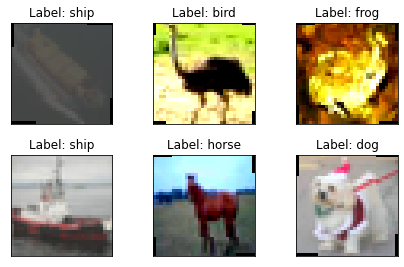

In [ ]:
# визуализируем аугментированные картинки
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(np.transpose(example_data[i], (1, 2, 0)), interpolation='none')
  plt.title(f"Label: {classes[example_targets[i]]}")
  plt.xticks([])
  plt.yticks([])

### Практическое задание №3

Реализовать (без обучения) сеть AlexNet. С помощью функции summary вывести результат работы сети на изображении размером (3, 224, 224)

In [ ]:
# your code here

# Создаем класс сети и заполняем согласно архитектуре AlexNet
class AlexNet(nn.Module):
    def __init__(self, num_classes, dropout=0.5):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(256*6*6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


model = AlexNet(1000).to(device)

# Посмотрим на модель
print(model)
summary(model, (3, 224, 224))

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

### Использование предобученных моделей

В качестве baseline model бывает удобно загрузить предобученную на большом датасете сеть и сразу же без дообучения использовать ее.

**Рассмотрим применение предобученной сети EfficientNet для классификации объекта на изображении:**

In [ ]:
# Установим библиотеку для EfficientNet PyTorch
!pip install efficientnet_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=75d311d4e9e7d609d26030c5e1d08aa6cad5f07f0f6dcbb9b1476735fb63017f
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch


In [ ]:
import json
import urllib
from PIL import Image
import time
import torch
from torchvision import transforms
from efficientnet_pytorch import EfficientNet
from urllib.request import urlopen

In [ ]:
# Выберем одну из разновидносетй посмотрим размер входного изображения
model_name = 'efficientnet-b0'
image_size = EfficientNet.get_image_size(model_name)

image_size

224

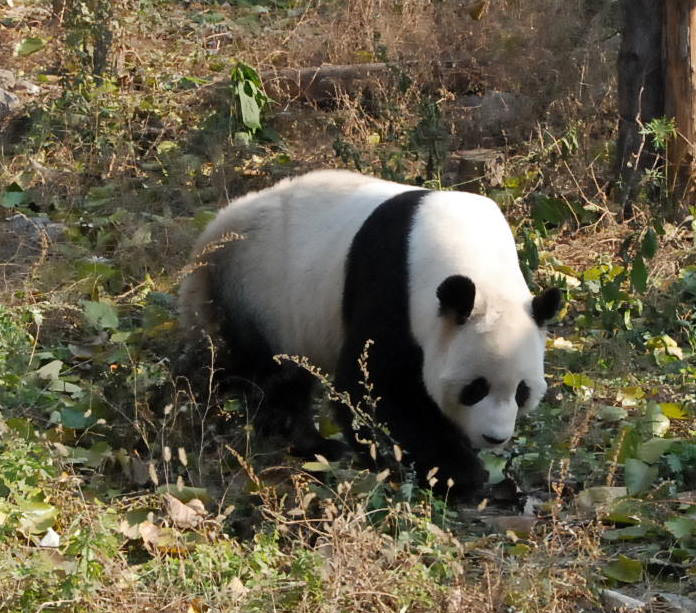

In [ ]:
# Загрузим изображение по ссылке
image_url = "https://raw.githubusercontent.com/lukemelas/EfficientNet-PyTorch/master/examples/simple/img.jpg"
data_url = "https://raw.githubusercontent.com/lukemelas/EfficientNet-PyTorch/master/examples/simple/labels_map.txt"

image = Image.open(urlopen(image_url))
image

In [ ]:
# Предобработаем изображение
tfms = transforms.Compose([transforms.Resize(image_size), transforms.CenterCrop(image_size), 
                           transforms.ToTensor(),
                           transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),])
image = tfms(image).unsqueeze(0)
image.shape

torch.Size([1, 3, 224, 224])

In [ ]:
# Загрузим названия классов
labels_map = json.load(urlopen(data_url))
labels_map = [labels_map[str(i)] for i in range(1000)]

print("Num classes:", len(labels_map))
labels_map[:5]

Num classes: 1000


['tench, Tinca tinca',
 'goldfish, Carassius auratus',
 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 'tiger shark, Galeocerdo cuvieri',
 'hammerhead, hammerhead shark']

In [ ]:
# Применим сеть к загруженной картинке

model = EfficientNet.from_pretrained(model_name)
model.eval()

start = time.time()
with torch.no_grad():
    logits = model(image)
preds = torch.topk(logits, k=5).indices.squeeze(0).tolist()
print("testing time: ", time.time() - start, " seconds")

print('----------------------------------------------------------------------------------')
for idx in preds:
    label = labels_map[idx]
    prob = torch.softmax(logits, dim=1)[0, idx].item()
    print('{:<75} ({:.2f}%)'.format(label, prob*100))

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b0
testing time:  0.19387221336364746  seconds
----------------------------------------------------------------------------------
giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca           (83.44%)
brown bear, bruin, Ursus arctos                                             (0.62%)
lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens         (0.60%)
ice bear, polar bear, Ursus Maritimus, Thalarctos maritimus                 (0.44%)
Arctic fox, white fox, Alopex lagopus                                       (0.34%)


### Trasnfer learning

[Transfer Learning](https://arxiv.org/abs/1808.01974v) - это процесс дообучения на *новых данных* какой-либо нейросети, предобученной до этого на других данных. Обычно предобучение производят на хорошем, большом (миллионы картинок) датасете (например, ImageNet ~ 14 млн картинок).

На данный момент есть множество предобученных моделей: `AlexNet`, `DenseNet`, `ResNet`, `VGG`, `Inception` и другие, а также их различные модификации. Все они отличаются архитектурой и входными данными.

**Описание метода**

Представим, что eсть новый набор данных, и вы хотите научить сеть классифицировать объекты из этой выборки.  

* **1. Fine Tuning** (дообучение CNN)  
   * Берём сеть, обученную на ImageNet;
   * Убираем последние Fully-Connected слои сети, отвечающие за классификацию;
   * Размораживаем все или несколько предыдущих слоев сети (`param.requires_grad = True`), начиная с последнего (**не** с первого);
   * Обучаем получившуюся архитектуру на новых данных (пару FC-слоёв, например).

* **2. Feature Extractor** (CNN как средство для извлечения признаков)
    * Берём сеть, обученную на ImageNet;
    * Убираем последние Fully-Connected слои сети, отвечающие за классификацию;
    * Замораживаем (`param.requires_grad = False`) веса всех предыдущих слоёв 
    * Обучаем на выходах полученной сети свой классификатор (пару FC-слоёв, например) на новых данных.

Ниже эти подходы изображены на примере VGG архитектуры:
    
<img src="https://sun9-66.userapi.com/c857632/v857632819/1ea161/rtU9L7NIrag.jpg" alt="tfl" width="600"/>

<style>
div.input {

В зависимости от количества и природы Ваших данных есть выбор из **нескольких стратегий Transfer Learning**, а именно:

* *У Вас **мало данных** ($\le 10k$), и они **похожи** на данные, на которых была обучена сеть до этого*  

    * если данные совсем похожи, можно попробовать использовать готовую модель
    * если качество Вас не устраивает, то тогда стоит обратиться к методу Feature Extractor
    * Fine Tuning лучше не использовать. Так как данные похожи на те, на которых обучалась сеть, то высокоуровневые признаки, полученные с помощью последних слоёв сети, должны оказаться информативными. Если делать в этом случае Fine-Tuning, то сеть может переобучиться, поскольку данных мало

* *У Вас **мало данных** ($\le 10k$), и они **не похожи** на данные, на которых была обучена сеть до этого*  
    * в данном случае мы *не можем* ожидать от сети, что выходы последних слоёв будут информативными для новых данных. Следует использовать Feature Extractor, но брать как признаки выходы более ранних слоёв. Ведь, как ожидается, они соответствуют более общим паттернам в данных.
* *У Вас **много данных** ($\ge 10k$), и они **похожи** на данные, на которых была обучена сеть до этого*  
    * можно попробовать использовать готовую модель
    * если качество Вас не устраивает, то тогда стоит cделать Fine-Tuning, ведь данных много, и вероятность переобучения меньше. Имеет смысл попробовать разморохить веса последних нескольких слоёв (можно разморозить и всю сеть)
* *У Вас **много данных** ($\ge 10k$), и они **не похожи** на данные, на которых была обучена сеть до этого*
    * Fine-Tuning практически всей сети. Веса предобученной сети оставляют в качестве инициализации для обучения на новых данных
    
display:none;
}
</style>

В зависимости от нового датасета имеет смысл использовать разные стратегии дообучения:
- если датасет *похож* на тот, на котором модель предобучена, то возможно стоит просто заменить слой классификации;
- если датасет *не похож*, то возможно стоит разморозить и сверточные слои тоже. 

**Эмпирическое правило**: *чем больше новый датасет не похож* на тот, на котором обучали модель, *тем больше слоев с конца стоит размораживать*.

Если новый датасет достаточно большой (на каждый класс > 1000 изображений), то можно попробовать разморозить всю нейросеть и обучить со случайных весов, как мы это делали до того, как узнали про Transfer Learning.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data
import torchvision.models as models

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time

In [ ]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
# Загрузим предобученную модель и посмотрим на нее
pretrained_model = models.vgg11_bn(pretrained=True)

print(pretrained_model)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG11_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /root/.cache/torch/hub/checkpoints/vgg11_bn-6002323d.pth


  0%|          | 0.00/507M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [ ]:
# Посмотрим на последний слой сети
pretrained_model.classifier[-1]

Linear(in_features=4096, out_features=1000, bias=True)

In [ ]:
# Изменим последний слой сети
IN_FEATURES = pretrained_model.classifier[-1].in_features # количество входов в последний слой
OUTPUT_DIM = 10 # количество выходов (равно количеству классов)

final_fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)
pretrained_model.classifier[-1] = final_fc

pretrained_model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=10, bias=True)
)

In [ ]:
# Создаем класс сети
class VGG(nn.Module):
  def __init__(self, features, output_dim):
      super().__init__()

      self.features = features

      self.avgpool = nn.AdaptiveAvgPool2d(7)

      self.classifier = nn.Sequential(
          nn.Linear(512 * 7 * 7, 4096),
          nn.ReLU(inplace=True),
          nn.Dropout(0.5),
          nn.Linear(4096, 4096),
          nn.ReLU(inplace=True),
          nn.Dropout(0.5),
          nn.Linear(4096, output_dim),
      )

  def forward(self, x):
      x = self.features(x)
      x = self.avgpool(x)
      x = x.view(x.shape[0], -1)
      x = self.classifier(x)

      return x

In [ ]:
def get_vgg_layers(config, batch_norm):
  """
  Функция сборки нейронной сети по слоям
  """
  layers = []
  in_channels = 3

  for c in config:
      assert c == 'M' or isinstance(c, int)
      if c == 'M':
          layers += [nn.MaxPool2d(kernel_size=2)]
      else:
          conv2d = nn.Conv2d(in_channels, c, kernel_size=3, padding=1)
          if batch_norm:
              layers += [conv2d, nn.BatchNorm2d(c), nn.ReLU(inplace=True)]
          else:
              layers += [conv2d, nn.ReLU(inplace=True)]
          in_channels = c

  return nn.Sequential(*layers)

In [ ]:
# Несколько модификаций сети VGG (разное количество слоев)
vgg11_config = [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']
vgg13_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512,
                512, 'M']
vgg16_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512,
                'M', 512, 512, 512, 'M']
vgg19_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512,
                512, 512, 'M', 512, 512, 512, 512, 'M']

vgg11_layers = get_vgg_layers(vgg11_config, batch_norm=True)

vgg11_layers

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU(inplace=True)
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU(inplace=True)
  (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): ReLU(inplace=True)
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

In [ ]:
# Создаем сеть и загружаем в нее веси из предобученной сети
model = VGG(vgg11_layers, OUTPUT_DIM).to(device)
model.load_state_dict(pretrained_model.state_dict())

# Посмотрим на сеть
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5          [-1, 128, 16, 16]          73,856
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
         MaxPool2d-8            [-1, 128, 8, 8]               0
            Conv2d-9            [-1, 256, 8, 8]         295,168
      BatchNorm2d-10            [-1, 256, 8, 8]             512
             ReLU-11            [-1, 256, 8, 8]               0
           Conv2d-12            [-1, 256, 8, 8]         590,080
      BatchNorm2d-13            [-1, 256, 8, 8]             512
             ReLU-14            [-1, 25

Epoch 20 of 20 took 18.966s
  training loss (in-iteration): 	0.023083
  validation loss (in-iteration): 	1.345806
  training accuracy: 			99.29 %
  validation accuracy: 			74.22 %


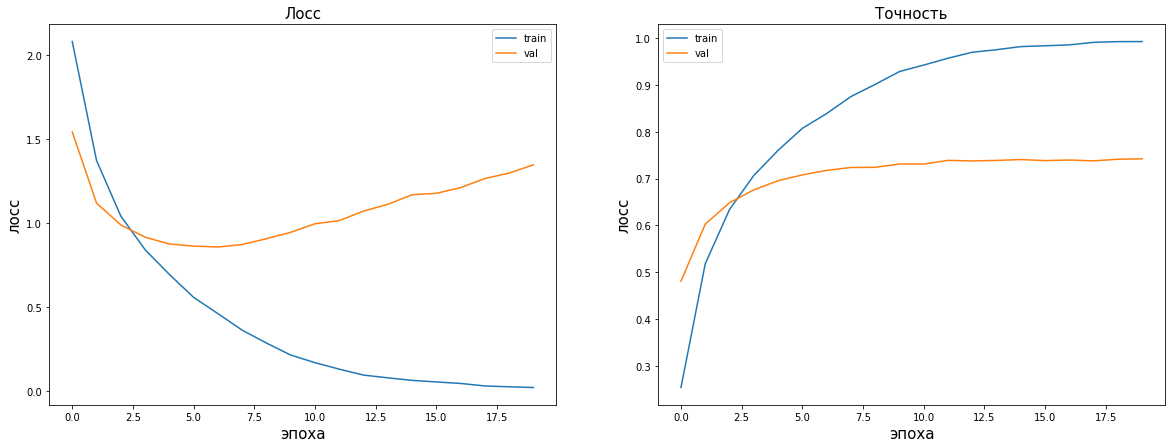

In [ ]:
# Выбираем функцию ошибок и оптимизатор
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

# Обучаем сеть
model, history = train(
    model, criterion, optimizer,
    val_loader, test_loader,
    num_epochs=20
)

### Домашнее задание

С помощью CNN решить задачу множественной классификации изображений, в качестве данных использовать датасет CIFAR-10. Добиться точности классификации на тестовой выборке не менее 90%. Провести анализ ошибок - вычислить и построить гистограммы precision и recall для каждого класса, построить графики зависимости ошибок и точности тестовой и обучающей выборок в зависимости от эпох обучения.